# Application of Downscaling Methods using Clmate Data as an example of Uganda International Education

## 1. Import required Python Libraries

In [1]:
import sys
import random

import xarray
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

from CCdownscaling import correction_downscale_methods, distribution_tests, error_metrics, som_downscale, utilities

import warnings
warnings.filterwarnings("ignore")

# for reproducibility
seed = 1
random.seed(seed)

/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/frame

## 2. Read Observation Weather data

* I couldn't find good quality weather data in Uganda, therefore, I used observation weather data that was provided by the original study to develop this downscaling method. https://egusphere.copernicus.org/preprints/2022/egusphere-2022-282/

In [2]:
# set downscaling variable and station id
downscaling_target='precip'
station_id='725300-94846'

In [3]:
# read observation weather data
station_data = pd.read_csv('./data/stations/' + station_id + '.csv')
station_data = station_data.replace(to_replace=[99.99, 9999.9], value=np.nan)
station_data

,Unnamed: 0,date,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,0,1946-10-09,46.1,74.3,*,64.4,*,0.00,I,NaN
1,1,1946-10-10,52.4,80.2,*,53.4,*,0.00,I,NaN
2,2,1946-10-11,47.1,76.3,*,47.3,*,NaN,,NaN
3,3,1946-10-12,32.0,48.4,*,33.4,*,0.00,I,NaN
4,4,1946-10-13,32.7,65.3,*,29.3,*,0.00,I,NaN
...,...,...,...,...,...,...,...,...,...,...
26148,26148,2021-05-16,47.0,72.0,,55.0,,0.01,G,1021.1
26149,26149,2021-05-17,48.7,72.0,,55.0,,0.00,G,1021.0
26150,26150,2021-05-18,54.6,75.9,,55.9,,0.00,G,1022.1
26151,26151,2021-05-19,61.2,75.9,,57.9,,0.07,G,1021.1


In [4]:
import datetime
dt_series = []
for date in station_data['date']:
    datetimeobj = datetime.datetime(int(str(date)[0:4]), int(str(date)[5:7]), int(str(date)[8:10]))
    dt_series.append(datetimeobj)
dt_series

[datetime.datetime(1946, 10, 9, 0, 0),
 datetime.datetime(1946, 10, 10, 0, 0),
 datetime.datetime(1946, 10, 11, 0, 0),
 datetime.datetime(1946, 10, 12, 0, 0),
 datetime.datetime(1946, 10, 13, 0, 0),
 datetime.datetime(1946, 10, 14, 0, 0),
 datetime.datetime(1946, 10, 15, 0, 0),
 datetime.datetime(1946, 10, 16, 0, 0),
 datetime.datetime(1946, 10, 17, 0, 0),
 datetime.datetime(1946, 10, 18, 0, 0),
 datetime.datetime(1946, 10, 19, 0, 0),
 datetime.datetime(1946, 10, 20, 0, 0),
 datetime.datetime(1946, 10, 21, 0, 0),
 datetime.datetime(1946, 10, 22, 0, 0),
 datetime.datetime(1946, 10, 23, 0, 0),
 datetime.datetime(1946, 10, 24, 0, 0),
 datetime.datetime(1946, 10, 25, 0, 0),
 datetime.datetime(1946, 10, 26, 0, 0),
 datetime.datetime(1946, 10, 27, 0, 0),
 datetime.datetime(1946, 10, 28, 0, 0),
 datetime.datetime(1946, 10, 29, 0, 0),
 datetime.datetime(1946, 10, 30, 0, 0),
 datetime.datetime(1946, 10, 31, 0, 0),
 datetime.datetime(1946, 11, 1, 0, 0),
 datetime.datetime(1946, 11, 2, 0, 0),
 da

In [5]:
station_data["date"] = dt_series
station_data["precip"] = station_data["precip"]*2.54
station_data

,Unnamed: 0,date,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,0,1946-10-09,46.1,74.3,*,64.4,*,0.0000,I,NaN
1,1,1946-10-10,52.4,80.2,*,53.4,*,0.0000,I,NaN
2,2,1946-10-11,47.1,76.3,*,47.3,*,NaN,,NaN
3,3,1946-10-12,32.0,48.4,*,33.4,*,0.0000,I,NaN
4,4,1946-10-13,32.7,65.3,*,29.3,*,0.0000,I,NaN
...,...,...,...,...,...,...,...,...,...,...
26148,26148,2021-05-16,47.0,72.0,,55.0,,0.0254,G,1021.1
26149,26149,2021-05-17,48.7,72.0,,55.0,,0.0000,G,1021.0
26150,26150,2021-05-18,54.6,75.9,,55.9,,0.0000,G,1022.1
26151,26151,2021-05-19,61.2,75.9,,57.9,,0.1778,G,1021.1


## 3. Read GCM historical data

In [6]:
# read five nc files
gcm_data = xarray.open_dataset('./data/models/pr_day_HadGEM3-GC31-MM_historical_r1i1p1f3_gn_19470101-20141230_v20191207.nc')
gcm_data

<xarray.Dataset>
Dimensions:    (time: 24480, bnds: 2, lat: 4, lon: 3)
Coordinates:
  * time       (time) object 1947-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat        (lat) float64 24.17 24.72 25.28 25.83
  * lon        (lon) float64 66.25 67.08 67.92
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-18T02:12:00Z
    ...                     ...
    tracking_id:            hdl:21.14100/d3b35594-5a39-4d9d-b173-aa7e3a7431fa
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

### 3.1 Remove Feb-29, Feb-30 considering leap years

In [7]:
start_year = 1947
end_year = 2014
leap_years = list(range(start_year + (4 - start_year % 4), end_year + 1, 4))
leap_years.remove(leap_years[12])
no_leap_years = list(range(start_year, end_year + 1, 1))
li = no_leap_years
remove_set = {3, 5}

li = [i for i in li if i not in leap_years]
li

[1947,
 1949,
 1950,
 1951,
 1953,
 1954,
 1955,
 1957,
 1958,
 1959,
 1961,
 1962,
 1963,
 1965,
 1966,
 1967,
 1969,
 1970,
 1971,
 1973,
 1974,
 1975,
 1977,
 1978,
 1979,
 1981,
 1982,
 1983,
 1985,
 1986,
 1987,
 1989,
 1990,
 1991,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2001,
 2002,
 2003,
 2005,
 2006,
 2007,
 2009,
 2010,
 2011,
 2013,
 2014]

In [8]:
# remove Feb-30
for a_year in no_leap_years:
    gcm_data = gcm_data.sel(time=~((gcm_data.time.dt.year == a_year) & (gcm_data.time.dt.month == 2) & (gcm_data.time.dt.day == 30)))

In [9]:
# remove Feb-29
for a_year in li:
    gcm_data = gcm_data.sel(time=~((gcm_data.time.dt.year == a_year) & (gcm_data.time.dt.month == 2) & (gcm_data.time.dt.day == 29)))

In [10]:
gcm_data

<xarray.Dataset>
Dimensions:    (time: 24360, bnds: 2, lat: 4, lon: 3)
Coordinates:
  * time       (time) object 1947-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat        (lat) float64 24.17 24.72 25.28 25.83
  * lon        (lon) float64 66.25 67.08 67.92
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 1947-01-01 00:00:00 ... 2015-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-09-18T02:12:00Z
    ...                     ...
    tracking_id:            hdl:21.14100/d3b35594-5a39-4d9d-b173-aa7e3a7431fa
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

### 3.2 Set Station Lat and Lon

In [11]:
station_lat = 24.785
station_lon = 67.14587
station_lat, station_lon

(24.785, 67.14587)

### 3.3 Change precipitation unit and extract data using analysis periods, lat and lon

In [12]:
# load GCM historical data
gcm_data['pr'] = gcm_data['pr'] * 86400
gcm_precip1 = gcm_data['pr'].sel(time=slice('1947-01-01','2014-12-30'))
gcm_precip2 = gcm_precip1.sel(lat=station_lat, lon=station_lon, method='nearest').values
gcm_precip = np.squeeze(gcm_precip2)

In [13]:
total_date_df = pd.DataFrame(
    {'date': pd.date_range(start='1947-01-01', end='2013-09-10', freq='1D'),
    }
)
print(len(total_date_df))
total_date_df["gcm_precip"] = gcm_precip
total_date_df

24360


,date,gcm_precip
0,1947-01-01,5.379352e-05
1,1947-01-02,1.619850e-07
2,1947-01-03,1.265955e-04
3,1947-01-04,2.696945e-03
4,1947-01-05,2.402302e-03
...,...,...
24355,2013-09-06,1.715234e-02
24356,2013-09-07,5.196103e-03
24357,2013-09-08,1.222165e-02
24358,2013-09-09,1.075510e-04


## 4. Merge Station Observation and GCM historical data

In [14]:
total_data = pd.merge(total_date_df, station_data, on="date", how="left")
total_data

,date,gcm_precip,Unnamed: 0,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,1947-01-01,5.379352e-05,84.0,1.8,26.4,*,-1.7,*,NaN,,1036.1
1,1947-01-02,1.619850e-07,85.0,25.0,31.3,*,24.4,*,NaN,,1026.4
2,1947-01-03,1.265955e-04,86.0,17.3,30.4,*,12.4,*,NaN,,1025.3
3,1947-01-04,2.696945e-03,87.0,-2.1,12.4,*,-3.6,*,NaN,,1034.4
4,1947-01-05,2.402302e-03,88.0,-6.0,15.4,*,0.3,*,NaN,,1021.6
...,...,...,...,...,...,...,...,...,...,...,...
24355,2013-09-06,1.715234e-02,23339.0,53.5,86.0,,57.0,,0.0000,G,1021.8
24356,2013-09-07,5.196103e-03,23340.0,62.6,88.0,,57.0,,0.0000,G,1014.8
24357,2013-09-08,1.222165e-02,23341.0,66.1,88.0,,64.9,,0.0254,G,1014.6
24358,2013-09-09,1.075510e-04,23342.0,67.7,93.9,,68.0,,0.0000,G,1012.4


In [15]:
print(len(total_data[total_data.isna().any(axis=1)]))
total_data[total_data.isna().any(axis=1)]

3491


,date,gcm_precip,Unnamed: 0,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,1947-01-01,5.379352e-05,84.0,1.8,26.4,*,-1.7,*,NaN,,1036.1
1,1947-01-02,1.619850e-07,85.0,25.0,31.3,*,24.4,*,NaN,,1026.4
2,1947-01-03,1.265955e-04,86.0,17.3,30.4,*,12.4,*,NaN,,1025.3
3,1947-01-04,2.696945e-03,87.0,-2.1,12.4,*,-3.6,*,NaN,,1034.4
4,1947-01-05,2.402302e-03,88.0,-6.0,15.4,*,0.3,*,NaN,,1021.6
...,...,...,...,...,...,...,...,...,...,...,...
12112,1980-02-29,2.850161e-02,11096.0,0.6,21.9,*,1.0,*,NaN,,1029.4
14933,1987-11-20,1.460651e-01,13917.0,16.7,43.0,,24.1,,NaN,,1021.1
19035,1999-02-12,2.885820e-10,18019.0,20.1,NaN,,19.0,*,1.0414,G,1010.8
21203,2005-01-19,0.000000e+00,20187.0,20.5,35.1,*,17.6,*,NaN,,1016.1


In [16]:
# 결측이 없음을 확인함
col_name = list(total_data)
total_data[col_name] = total_data[col_name].interpolate(method="pad")
total_data[total_data.isna().any(axis=1)]

,date,gcm_precip,Unnamed: 0,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,1947-01-01,5.379352e-05,84.0,1.8,26.4,*,-1.7,*,NaN,,1036.1
1,1947-01-02,1.619850e-07,85.0,25.0,31.3,*,24.4,*,NaN,,1026.4
2,1947-01-03,1.265955e-04,86.0,17.3,30.4,*,12.4,*,NaN,,1025.3
3,1947-01-04,2.696945e-03,87.0,-2.1,12.4,*,-3.6,*,NaN,,1034.4
4,1947-01-05,2.402302e-03,88.0,-6.0,15.4,*,0.3,*,NaN,,1021.6


In [17]:
total_data = total_data.fillna(0)
total_data

,date,gcm_precip,Unnamed: 0,dew_point,max_temp,max_temp_flag,min_temp,min_temp_flag,precip,precip_flag,sea_level_pressure
0,1947-01-01,5.379352e-05,84.0,1.8,26.4,*,-1.7,*,0.0000,,1036.1
1,1947-01-02,1.619850e-07,85.0,25.0,31.3,*,24.4,*,0.0000,,1026.4
2,1947-01-03,1.265955e-04,86.0,17.3,30.4,*,12.4,*,0.0000,,1025.3
3,1947-01-04,2.696945e-03,87.0,-2.1,12.4,*,-3.6,*,0.0000,,1034.4
4,1947-01-05,2.402302e-03,88.0,-6.0,15.4,*,0.3,*,0.0000,,1021.6
...,...,...,...,...,...,...,...,...,...,...,...
24355,2013-09-06,1.715234e-02,23339.0,53.5,86.0,,57.0,,0.0000,G,1021.8
24356,2013-09-07,5.196103e-03,23340.0,62.6,88.0,,57.0,,0.0000,G,1014.8
24357,2013-09-08,1.222165e-02,23341.0,66.1,88.0,,64.9,,0.0254,G,1014.6
24358,2013-09-09,1.075510e-04,23342.0,67.7,93.9,,68.0,,0.0000,G,1012.4


## 6. Split train and test sets

In [18]:
# split train and test sets:
# train_split = int(round(input_data.shape[0]*0.8))
input_data = total_data["gcm_precip"]
hist_data = total_data["precip"]
train_split = int(len(total_data)*0.8)  # split out the first 24 years for the training data, last 6 years for the test set
training_data = input_data[0:train_split].values.reshape(-1, 1)
train_hist = hist_data[0:train_split].values.reshape(-1, 1)
test_data = input_data[train_split:].values.reshape(-1, 1)
test_hist = hist_data[train_split:].values.reshape(-1, 1)
#rean_precip_train = rean_precip[0:train_split]
#rean_precip_test = rean_precip[train_split:]
print(training_data.shape, test_data.shape)

(19488, 1) (4872, 1)


In [19]:
# intialize the different methods
#som = som_downscale(som_x=7, som_y=5, batch=512, alpha=0.1, epochs=50)
rf_two_part = correction_downscale_methods.two_step_random_forest()
random_forest = sklearn.ensemble.RandomForestRegressor()
qmap = correction_downscale_methods.quantile_mapping()
linear = sklearn.linear_model.LinearRegression()

## 7. Train Climate Data

In [20]:
# train
#som.fit(training_data, train_hist, seed=1)
random_forest.fit(training_data, train_hist)
rf_two_part.fit(training_data, train_hist)
linear.fit(training_data, train_hist)
qmap.fit(training_data, train_hist)

(4764, 1) (4764, 1)


array([  0.        ,   0.        ,   0.        , ...,  43.32215747,
        90.58492686, 159.75844019])

## 8. Test and Visualize Climate data 

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [22]:
# generate outputs from the test data
#som_output = som.predict(test_data)
random_forest_output = random_forest.predict(test_data)
rf_two_part_output = rf_two_part.predict(test_data)
qmap_output = qmap.predict(test_data)

In [23]:
mse = mean_squared_error(test_hist, random_forest_output)
mae = mean_absolute_error(test_hist, random_forest_output)
r2 = r2_score(test_hist, random_forest_output)
mse, mae, r2

(0.9584463909969126, 0.3688077115361806, -0.16097779645719612)

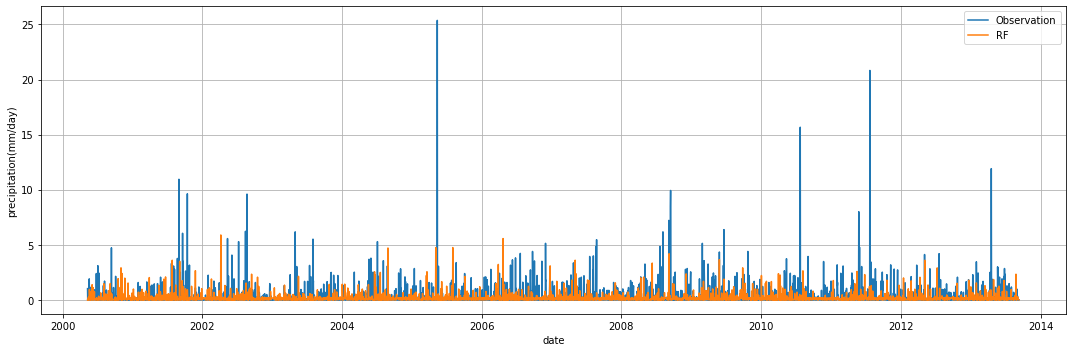

In [24]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["date"][train_split:].values, test_hist, total_data["date"][train_split:].values, random_forest_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'RF'])
fig.tight_layout()
plt.show()

In [25]:
mse = mean_squared_error(test_hist, rf_two_part_output)
mae = mean_absolute_error(test_hist, rf_two_part_output)
r2 = r2_score(test_hist, rf_two_part_output)
mse, mae, r2

(0.9710046769090035, 0.33472272310154755, -0.1761898012625287)

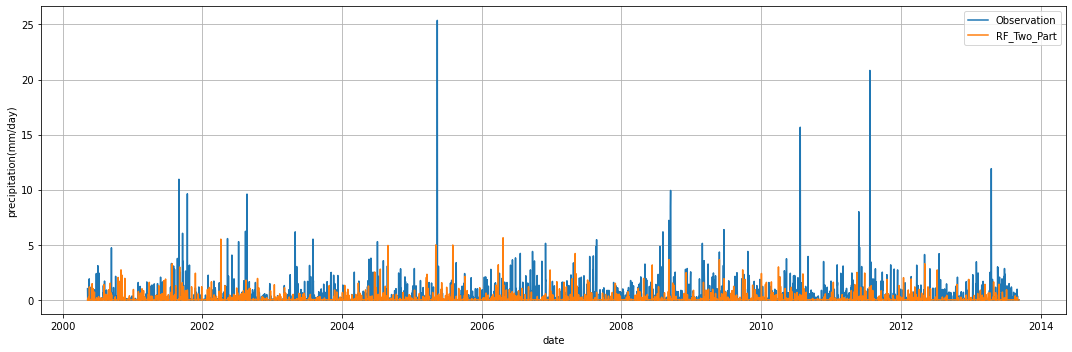

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["date"][train_split:].values, test_hist, total_data["date"][train_split:].values, rf_two_part_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'RF_Two_Part'])
fig.tight_layout()
plt.show()

In [27]:
mse = mean_squared_error(test_hist, qmap_output)
mae = mean_absolute_error(test_hist, qmap_output)
r2 = r2_score(test_hist, qmap_output)
mse, mae, r2

(1.2094686871277924, 0.39994113184820046, -0.46504416361261613)

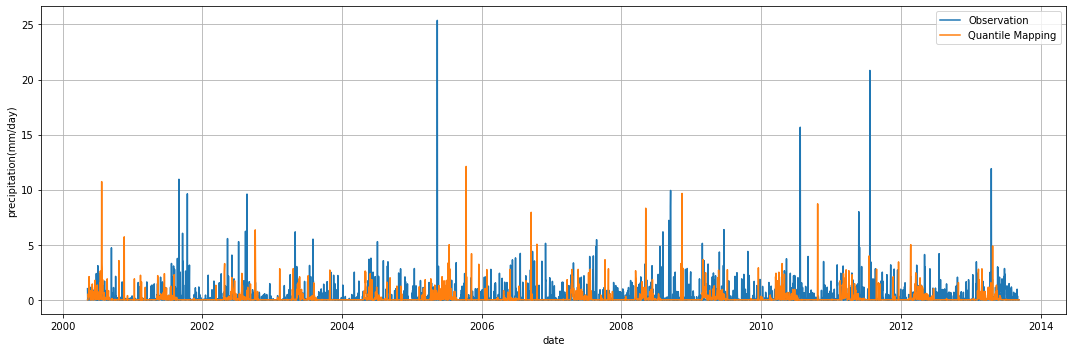

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_data["date"][train_split:].values, test_hist, total_data["date"][train_split:].values, qmap_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['Observation', 'Quantile Mapping'])
fig.tight_layout()
plt.show()

## 9. Create Future Precipitations

In [29]:
# read five nc files
scenario_data = xarray.open_dataset('./data/models/pr_day_HadGEM3-GC31-MM_ssp585_r1i1p1f3_gn_20220101-21001230_v20200515.nc')
scenario_data

<xarray.Dataset>
Dimensions:    (time: 28440, bnds: 2, lat: 2, lon: 2)
Coordinates:
  * time       (time) object 2022-01-01 12:00:00 ... 2100-12-30 12:00:00
  * lat        (lat) float64 24.17 24.72
  * lon        (lon) float64 67.08 67.92
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2020-05-05T07:44:59Z
    ...                     ...
    tracking_id:            hdl:21.14100/09cc2485-f76e-4d74-a16f-6af21763310b
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

### 9.1 Remove Feb-29, Feb-30 considering leap years

In [30]:
start_year = 2022
end_year = 2100
leap_years = list(range(start_year + (4 - start_year % 4), end_year + 1, 4))
leap_years.remove(leap_years[12])
no_leap_years = list(range(start_year, end_year + 1, 1))
li = no_leap_years
remove_set = {3, 5}

li = [i for i in li if i not in leap_years]
li

[2022,
 2023,
 2025,
 2026,
 2027,
 2029,
 2030,
 2031,
 2033,
 2034,
 2035,
 2037,
 2038,
 2039,
 2041,
 2042,
 2043,
 2045,
 2046,
 2047,
 2049,
 2050,
 2051,
 2053,
 2054,
 2055,
 2057,
 2058,
 2059,
 2061,
 2062,
 2063,
 2065,
 2066,
 2067,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2077,
 2078,
 2079,
 2081,
 2082,
 2083,
 2085,
 2086,
 2087,
 2089,
 2090,
 2091,
 2093,
 2094,
 2095,
 2097,
 2098,
 2099]

In [31]:
# remove Feb-30
for a_year in no_leap_years:
    scenario_data = scenario_data.sel(time=~((scenario_data.time.dt.year == a_year) & (scenario_data.time.dt.month == 2) & (scenario_data.time.dt.day == 30)))

In [32]:
# remove Feb-29
for a_year in li:
    scenario_data = scenario_data.sel(time=~((scenario_data.time.dt.year == a_year) & (scenario_data.time.dt.month == 2) & (scenario_data.time.dt.day == 29)))

In [33]:
scenario_data

<xarray.Dataset>
Dimensions:    (time: 28301, bnds: 2, lat: 2, lon: 2)
Coordinates:
  * time       (time) object 2022-01-01 12:00:00 ... 2100-12-30 12:00:00
  * lat        (lat) float64 24.17 24.72
  * lon        (lon) float64 67.08 67.92
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 2022-01-01 00:00:00 ... 2101-01-01 00:00:00
    lat_bnds   (time, lat, bnds) float64 ...
    lon_bnds   (time, lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   59400.0
    branch_time_in_parent:  59400.0
    creation_date:          2020-05-05T07:44:59Z
    ...                     ...
    tracking_id:            hdl:21.14100/09cc2485-f76e-4d74-a16f-6af21763310b
    variable_id:            pr
    variable_name:          pr
    variant_label:          r1i1p1f3
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0

### 3.2 Set Station Lat and Lon

In [34]:
station_lat = 24.785
station_lon = 67.14587
station_lat, station_lon

(24.785, 67.14587)

### 3.3 Change precipitation unit and extract data using analysis periods, lat and lon

In [36]:
# load GCM historical data
scenario_data['pr'] = scenario_data['pr'] * 86400
scenario_data1 = scenario_data['pr'].sel(time=slice('2022-01-01','2100-12-30'))
scenario_data2 = scenario_data1.sel(lat=station_lat, lon=station_lon, method='nearest').values
scenario_precip = np.squeeze(scenario_data2)

In [42]:
total_date_df = pd.DataFrame(
    {'date': pd.date_range(start='2022-01-01', end='2099-06-26', freq='1D'),
    }
)
print(len(total_date_df))
total_date_df["scenario_precip"] = scenario_precip
total_date_df

28301


,date,scenario_precip
0,2022-01-01,0.000000
1,2022-01-02,0.000000
2,2022-01-03,0.019437
3,2022-01-04,0.260791
4,2022-01-05,99.357068
...,...,...
28296,2099-06-22,0.000000
28297,2099-06-23,0.141361
28298,2099-06-24,0.387552
28299,2099-06-25,0.000000


In [43]:
scenario_precip.reshape(-1, 1)

array([[0.        ],
       [0.        ],
       [0.01943656],
       ...,
       [0.38755166],
       [0.        ],
       [0.        ]])

In [44]:
# generate outputs from the test data
random_forest_output = random_forest.predict(scenario_precip.reshape(-1, 1))
rf_two_part_output = rf_two_part.predict(scenario_precip.reshape(-1, 1))
qmap_output = qmap.predict(scenario_precip.reshape(-1, 1))

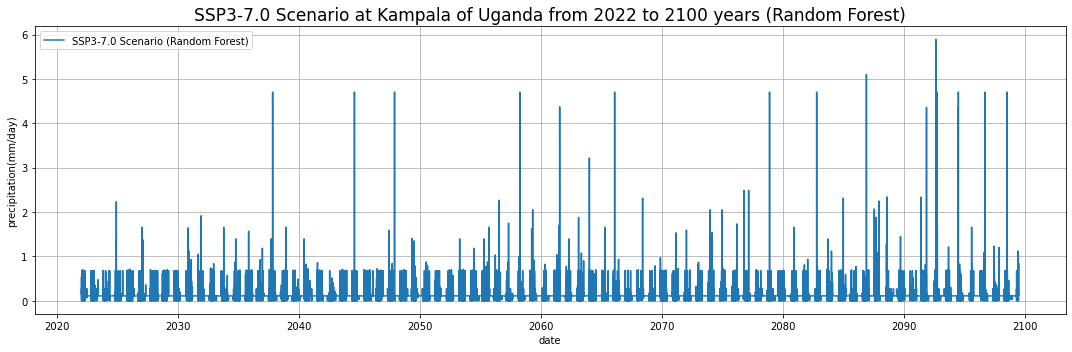

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, random_forest_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Random Forest)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Random Forest)', fontsize=17)
fig.tight_layout()
plt.show()

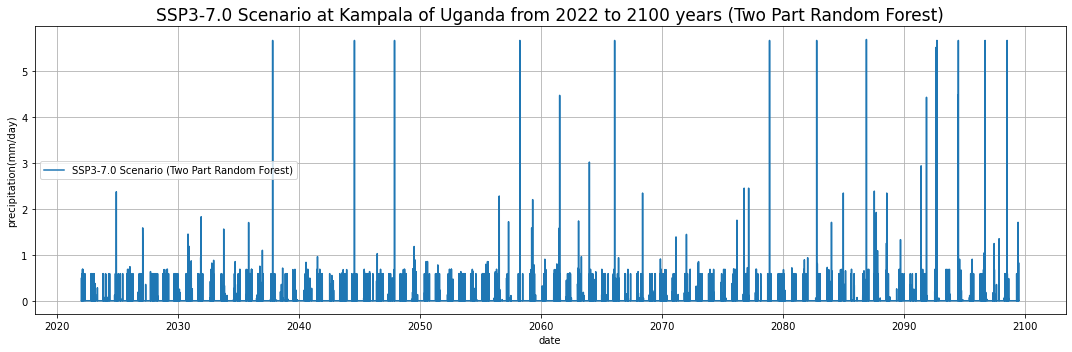

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, rf_two_part_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Two Part Random Forest)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Two Part Random Forest)', fontsize=17)
fig.tight_layout()
plt.show()

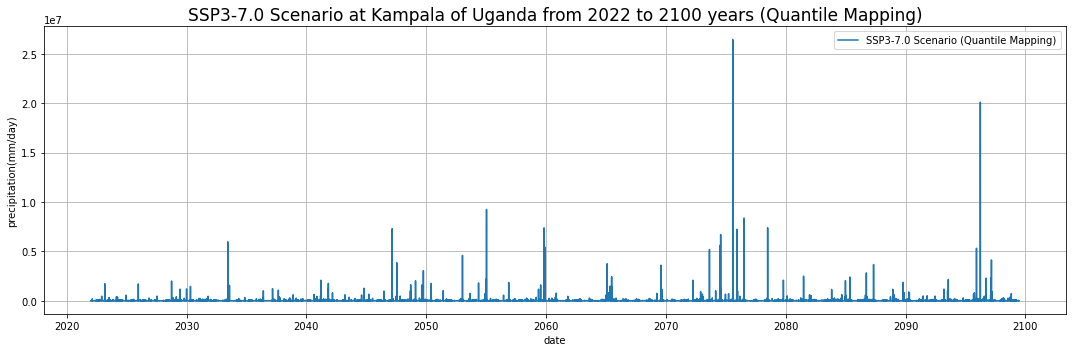

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(total_date_df["date"].values, qmap_output)
ax.set_xlabel('date')
ax.set_ylabel('precipitation(mm/day)')
ax.grid(True)
ax.legend(['SSP3-7.0 Scenario (Quantile Mapping)'])
plt.title('SSP3-7.0 Scenario at Kampala of Uganda from 2022 to 2100 years (Quantile Mapping)', fontsize=17)
fig.tight_layout()
plt.show()